In [1]:
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib

In [31]:
d = 1
sigma_theta =torch.eye(d)
mu_theta =torch.zeros(d)
prior_distribution = torch.distributions.MultivariateNormal(mu_theta, sigma_theta) 

prior_log_prob = lambda samples: prior_distribution.log_prob(samples)

num_samples = 2
theta =prior_distribution.sample([num_samples])

sigma_simulateur = .5
f = lambda y: 1*torch.ones(d)@y.T+1
simulateur= lambda theta: f(theta) + torch.randn(theta.shape[0])*sigma_simulateur

x = simulateur(theta)

theta_0 = torch.ones(d)
number_observations= 20
x0 = simulateur(theta_0.unsqueeze(0).repeat(number_observations, 1))

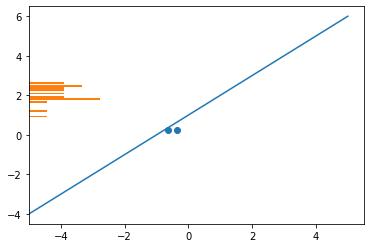

In [32]:
plt.scatter(theta[:,0].numpy(), x.numpy())
tt = torch.linspace(-5,5,100)
plt.plot(tt,f(tt.unsqueeze(-1)))
hist = plt.hist(x0.numpy(), orientation ='horizontal', bins = 20, density = True, bottom = -5)

In [35]:
def plot_models(models):
    if models.shape[-1]<=2:
        plt.figure()
        tt = torch.linspace(-5,5,100)
        theta_tt = torch.cat([tt.unsqueeze(-1), torch.ones(tt.shape[0]).unsqueeze(-1)], dim = -1)
        x_tt = models@theta_tt.T
        probability = torch.exp(blr.parameter_posterior_distribution.log_prob(models))
        for i in range(models.shape[0]):
            plt.plot(tt, x_tt[i], color = 'black' )
    plt.figure()
    plt.scatter(models[:,-1].numpy(), models[:,-2].numpy())
    plt.show()
    
def plot_2d_function(f, x_min = -10,x_max = 10, y_min = -10, y_max = 10, delta = 200, levels = 2 , alpha = 0.7, new_figure = True):
    if new_figure :
        plt.figure(figsize = (10,10))
        plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    tt_x = torch.linspace(x_min, x_max, delta)
    tt_y = torch.linspace(y_min,y_max, delta)
    mesh = torch.cartesian_prod(tt_x, tt_y)
    with torch.no_grad():
        plt.contourf(tt_x,tt_y,f(mesh).numpy().reshape(delta,delta).T, levels = levels, cmap = matplotlib.cm.get_cmap('viridis'), alpha = alpha)
        plt.legend()

In [36]:
class bayesian_linear_regression:
    def __init__(self, x_samples, theta_samples, x0, sigma_simulateur, mu_theta, sigma_theta): 
        self.x_samples = x_samples
        self.theta_samples = theta_samples
        self.num_samples = x_samples.shape[0]
        self.d = theta_samples.shape[-1]
        
        self.sigma_simulateur = sigma_simulateur
        self.mu_theta = mu_theta
        self.sigma_theta = sigma_theta 
        
        self.mu_phi = torch.zeros(self.d+1)
        self.sigma_phi = torch.eye(self.d+1)
        if self.num_samples >= 2:
            self.compute_parameter_likelihood()
        self.compute_parameter_posterior()

        self.x0=x0
    
    def compute_parameter_likelihood(self):
        assert self.num_samples>=2,'Must have more than 1 dataset sample'
        temp = torch.cat([self.theta_samples, torch.ones(self.theta_samples.shape[0]).unsqueeze(-1)], dim = -1)
        self.sigma_d_phi = torch.inverse(temp.T@temp)*self.sigma_simulateur**2
        self.mu_d_phi = self.x_samples@temp@torch.inverse(temp.T@temp)
        self.parameter_likelihood_distribution = torch.distributions.MultivariateNormal(self.mu_d_phi, self.sigma_d_phi)
        
    def dataset_likelihood(self, beta): 
        assert self.num_samples>=1,'No dataset'
        temp = torch.cat([self.theta_samples, torch.ones(self.theta_samples.shape[0]).unsqueeze(-1)], dim = -1)
        mean = beta@temp.T
        sigma = (self.sigma_simulateur**2)*torch.eye(self.d).unsqueeze(0).repeat(self.theta_samples.shape[0],1,1)
        return torch.distributions.MultivariateNormal(mean.unsqueeze(-1),sigma).log_prob(self.x_samples.unsqueeze(-1))
        
    def compute_parameter_posterior(self):
        if self.num_samples>=2:
            self.sigma_phi_d = torch.inverse(torch.inverse(self.sigma_d_phi) + torch.inverse(self.sigma_phi))
            self.mu_phi_d = self.sigma_phi_d@(torch.inverse(self.sigma_d_phi)@self.mu_d_phi+ torch.inverse(self.sigma_phi)@self.mu_phi)
            self.parameter_posterior_distribution = torch.distributions.MultivariateNormal(self.mu_phi_d, self.sigma_phi_d)
        else:
            temp = torch.cat([self.theta_samples, torch.ones(self.theta_samples.shape[0]).unsqueeze(-1)], dim = -1)
            self.sigma_phi_d = torch.inverse(temp.T@temp/self.sigma_simulateur**2 + torch.inverse(self.sigma_phi))
            self.mu_phi_d = self.sigma_phi_d@( self.x_samples@temp/self.sigma_simulateur**2+ torch.inverse(self.sigma_phi)@self.mu_phi)
            self.parameter_posterior_distribution = torch.distributions.MultivariateNormal(self.mu_phi_d, self.sigma_phi_d)

    def log_joint_distribution(self, theta, phi):
        log_prior = torch.distributions.MultivariateNormal(self.mu_theta, self.sigma_theta).log_prob(theta)
        augmented_theta = torch.cat([theta, torch.ones(theta.shape[0],1)], dim = -1)
        temp = torch.bmm(phi.unsqueeze(-2),augmented_theta.unsqueeze(-1)).squeeze(-1)
        temp = temp.repeat(1,self.x0.shape[0])
        cov_matrix = sigma_simulateur * torch.eye(self.x0.shape[0]).unsqueeze(0).repeat(theta.shape[0],1,1)
        log_likelihood = torch.distributions.MultivariateNormal(temp, cov_matrix).log_prob(self.x0) if self.x0.shape[0]>=1 else torch.zeros(theta.shape[0])
        log_parameter_posterior = self.parameter_posterior_distribution.log_prob(phi)
        return log_parameter_posterior+log_prior+log_likelihood
    
    def marginal_log_likelihood_parameters(self, x, theta): 
        gamma = torch.cat([theta, torch.ones(theta.shape[0],1)], dim = -1).unsqueeze(1).repeat(1,x.shape[0],1)
        mean = gamma@self.mu_phi_d
        cov = gamma@self.sigma_phi_d.unsqueeze(0).repeat(theta.shape[0],1,1)@torch.transpose(gamma, -2,-1) + self.sigma_simulateur*torch.eye(x.shape[0]).unsqueeze(0).repeat(theta.shape[0],1,1)
        return mean, cov
    
    def marginal_log_likelihood(self, x, theta):
        mean, cov = self.marginal_log_likelihood_parameters(x, theta)
        return torch.distributions.MultivariateNormal(mean, cov).log_prob(x)
    
    def sample_marginal_likelihood(self, num_samples, theta):
        mean, cov = self.marginal_log_likelihood_parameters(torch.zeros(num_samples), theta)
        return torch.distributions.MultivariateNormal(mean, cov).sample()

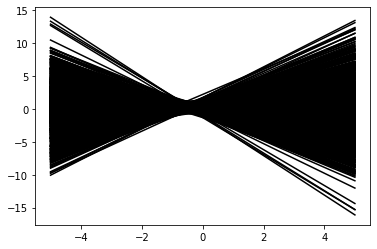

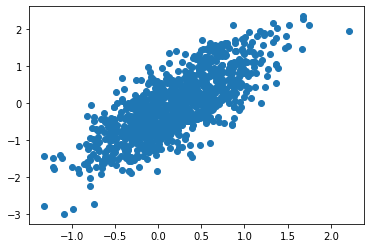

In [39]:
blr = bayesian_linear_regression(x, theta, x0, sigma_simulateur, mu_theta, sigma_theta)
models = blr.parameter_posterior_distribution.sample([1000])
plot_models(models)

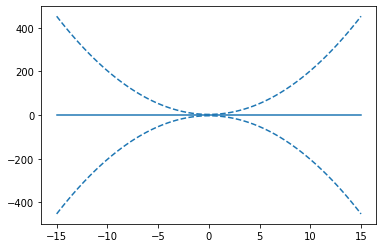

In [24]:
tt = torch.linspace(-15,15,100)
mean, cov =  blr.marginal_log_likelihood_parameters(torch.zeros(1), tt.unsqueeze(-1))
plt.plot(tt, mean)
plt.plot(tt,mean.squeeze(-1) + 2*cov.squeeze(-1).squeeze(-1), color = 'C0', linestyle = '--')
plt.plot(tt,mean.squeeze(-1) - 2*cov.squeeze(-1).squeeze(-1), color = 'C0', linestyle= '--')
sample = blr.sample_marginal_likelihood(10,tt.unsqueeze(-1))

In [25]:
#Sampling the posterior p(phi|D) with weighted likelihood bootstrap

number_chains = 1000
beta= torch.randn(number_chains,d+1)
beta.requires_grad_()
w = torch.distributions.dirichlet.Dirichlet(torch.ones(num_samples)).sample([number_chains])
epochs = 2000
optimizer = torch.optim.Adam([beta], lr = 5e-2)
pbar = tqdm(range(epochs))
for i in pbar:
    optimizer.zero_grad()
    loss = - torch.mean(torch.sum(blr.dataset_likelihood(beta)*w, dim = 1), dim=0)
    loss.backward()
    optimizer.step()
    pbar.set_postfix_str(str(loss.item()))
    
plot_models(beta.detach())
fig = plt.figure(figsize = (10,10))
plt.scatter(beta[:,0].detach().numpy(), beta[:,1].detach().numpy())
plot_2d_function(lambda samples:torch.exp(blr.parameter_posterior_distribution.log_prob(samples)),x_min = -2, x_max = 2,y_min = -2, y_max = 2,levels = 50, new_figure = False)

  0%|                                                                                                                                                            | 0/2000 [00:00<?, ?it/s]


AssertionError: No dataset

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


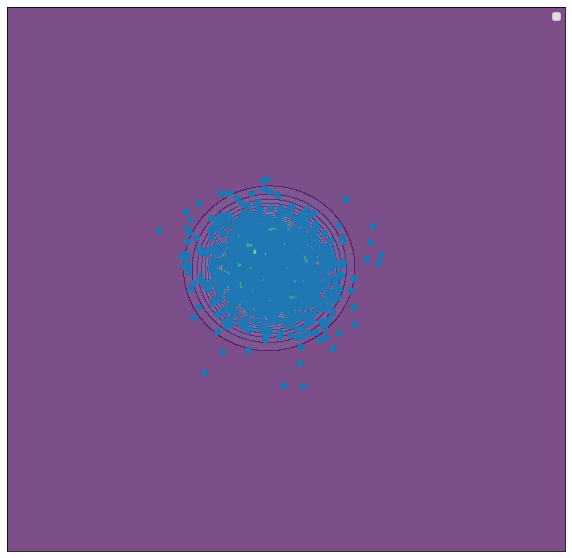

In [18]:
plot_2d_function(lambda samples:torch.exp(blr.parameter_posterior_distribution.log_prob(samples)),x_min = 0.8, x_max = 1.2,y_min = 0.8, y_max = 1.2,levels = 50, new_figure = True)
plt.scatter(beta[:,0].detach().numpy(), beta[:,1].detach().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.19it/s, acceptance rate = 0.012000000104308128]


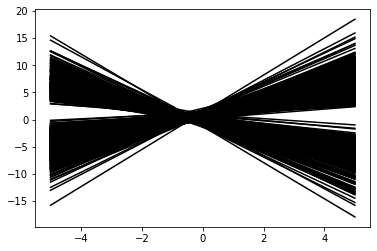

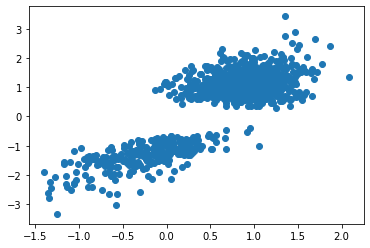

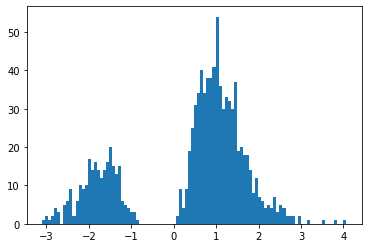

In [38]:
#Sampling the joint distribution p(phi, theta|x0, D) with IMH

mu_phi = torch.zeros(d+1)
sigma_phi = torch.eye(d+1)
def proposal_log_prob(theta,phi):
    log_prior_theta = torch.distributions.MultivariateNormal(mu_theta, sigma_theta).log_prob(theta)
    log_prior_phi = torch.distributions.MultivariateNormal(mu_phi, sigma_phi).log_prob(phi)
    return log_prior_theta + log_prior_phi

def propose(N):
    theta = torch.distributions.MultivariateNormal(mu_theta, sigma_theta).sample([N])
    phi = torch.distributions.MultivariateNormal(mu_phi, sigma_phi).sample([N])
    return theta, phi

def independant_MH(num_steps, theta0,phi0):
    current_phi = phi0
    current_theta = theta0
    pbar = tqdm(range(num_steps))
    for i in pbar:
        new_theta, new_phi = propose(current_phi.shape[0])
        acceptance_log_prob = blr.log_joint_distribution(new_theta, new_phi) - blr.log_joint_distribution(current_theta, current_phi) - proposal_log_prob(new_theta, new_phi) + proposal_log_prob(current_theta,current_phi)
        mask = (torch.rand(current_phi.shape[0])<torch.exp(acceptance_log_prob)).float().unsqueeze(-1)
        current_phi = (mask*1.)*new_phi + (1-(mask*1.))*current_phi
        current_theta =  (mask*1.)*new_theta + (1-(mask*1.))*current_theta
        pbar.set_postfix_str('acceptance rate = ' + str(torch.mean(mask).item()))
    return current_phi, current_theta

list_phi, list_theta = independant_MH(1000, torch.randn(1000,d), torch.randn(1000,d+1))
plot_models(list_phi)
plt.figure()
plt.hist(list_theta.numpy(), bins= 100)
plt.show()